In [46]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from open3d.pipelines.registration import registration_icp, TransformationEstimationPointToPoint
import copy


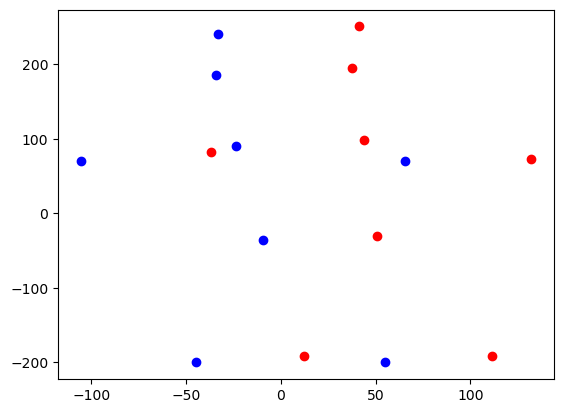

In [62]:
path = r'D:\StageE23\Data\Ete_2023\Participant19'

json_corr = open(os.path.join(path, r'Corrected\Prise01\Positions\positions_xyzr.json'))
pos_corr = json.load(json_corr)

json_auto = open(os.path.join(path, r'autocorrection\Prise01\Positions\positions_xyzr.json'))
pos_auto = json.load(json_auto)

x_corr, y_corr, z_corr = [], [], []
x_auto, y_auto, z_auto = [], [], []

for corr, auto in zip(pos_corr.values(), pos_auto.values()):
    x_corr, y_corr, z_corr = [], [], []
    x_auto, y_auto, z_auto = [], [], []
    for c_corr, c_auto in zip(corr.values(), auto.values()):
        x_corr.append(c_corr[0])
        y_corr.append(c_corr[1])
        z_corr.append(c_corr[2])
        x_auto.append(c_auto[0])
        y_auto.append(c_auto[1])
        z_auto.append(c_auto[2])
    
plt.scatter(x_auto, y_auto, c='b')
plt.scatter(x_corr, y_corr, c='r')
plt.show()

In [60]:
array_corr = np.array([x_corr, y_corr, z_corr])
array_auto = np.array([x_auto, y_auto, z_auto])

#while not np.allclose(array_auto, array_corr, atol = 50):
# Calcule les centrïdes
corr_centro = np.mean(array_corr, axis=1).reshape((-1,1))
auto_centro = np.mean(array_auto, axis=1).reshape((-1,1))

# Soustrait les centroïdes des coordos
q_corr = array_corr - corr_centro
q_auto = array_auto - auto_centro

# Matrice de covariance
H = np.matmul(q_corr, q_auto.transpose())
U, X, V_t = np.linalg.svd(H) # SVD de la matrice de covariance

# Matrice de rotation
R = np.matmul(V_t.transpose(), U.transpose())
print(np.linalg.det(R))
#assert np.allclose(np.linalg.det(R), 1.0)

# Matrice de translation
T = auto_centro - np.matmul(R, corr_centro)
print(T)

array_corr = T + np.matmul(R, array_corr)


-1.0000000000000002
[[816.05954898]
 [-50.51474637]
 [-76.90038199]]


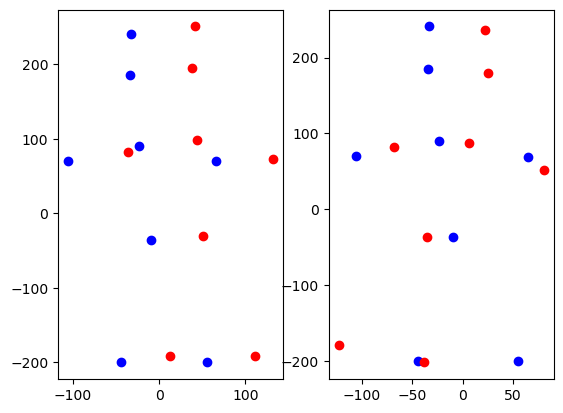

[1451.48689365 1394.17502981 1391.49255156 1423.80271973 1425.03776646
 1427.09653859 1411.94344344 1427.13149062]
[1470.28589655 1442.67193446 1418.22423704 1419.43134671 1437.24886665
 1361.8159916  1424.0587753  1378.42938555]


In [61]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.scatter(x_auto, y_auto, c='b')
ax1.scatter(x_corr, y_corr, c='r')
ax2.scatter(x_auto, y_auto, c='b')
ax2.scatter(array_corr[0,:], array_corr[1,:], c='r')
plt.show()

print(array_auto[2])
print(array_corr[2])

In [96]:
def ICP_registration(source, target):
    pc_target = o3d.geometry.PointCloud()
    pc_target.points = o3d.utility.Vector3dVector(target)
    pc_source = o3d.geometry.PointCloud()
    pc_source.points = o3d.utility.Vector3dVector(source)

    trans_init = np.eye(4)
    reg_p2p = registration_icp(pc_source, pc_target, 400, trans_init, TransformationEstimationPointToPoint())

    RMSE = reg_p2p.inlier_rmse

    pc_source_t = pc_source.transform(reg_p2p.transformation)
    source_trans = np.asarray(pc_source_t.points)

    return source_trans, RMSE

array_corr = np.array([x_corr, y_corr, z_corr]).T
array_auto = np.array([x_auto, y_auto, z_auto]).T

array_corr_t, RMSE = ICP_registration(array_corr, array_auto)

print(np.asarray(RMSE))


2.4100001154718913


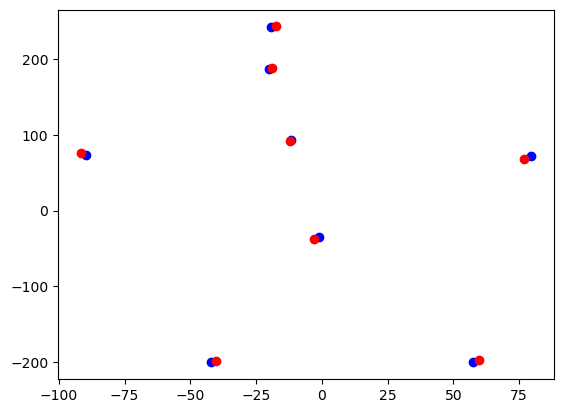

[1445.05113556 1382.21579998 1388.93406398 1412.20798761 1413.51028142
 1419.83442367 1402.90822426 1417.42381381]
[1447.67967536 1419.64728272 1402.21698373 1416.61411744 1380.38465388
 1388.31785332 1411.99180548 1415.23335836]


In [128]:
array_auto = np.asarray(array_auto).T
array_corr = np.asarray(array_corr_t).T

fig, ax1 = plt.subplots()
ax1.scatter(array_auto[0,:], array_auto[1,:], c='b')
ax1.scatter(array_corr[0,:], array_corr[1,:], c='r')
plt.show()

print(array_auto[2])
print(array_corr[2])

In [126]:
path = r'D:\StageE23\Data\Ete_2023\Participant19'

json_corr = open(os.path.join(path, r'Corrected\Prise01\Positions\positions_xyzr.json'))
pos_corr = json.load(json_corr)

json_auto = open(os.path.join(path, r'autocorrection\Prise01\Positions\positions_xyzr.json'))
pos_auto = json.load(json_auto)

array_corr = [[c_corr[0], c_corr[1], c_corr[2]] for c_corr in list(pos_corr.values())[len(pos_corr.values())//2].values()]
array_corr = np.asarray(array_corr)
print(array_corr)

arrays_auto = []
RMSEs = []
for auto in pos_auto.values():
    array_auto = []
    for c_auto in auto.values():
        array_auto.append([c_auto[0], c_auto[1], c_auto[2]])
    array_corr_t, RMSE = ICP_registration(array_corr, array_auto)
    #plt.figure()
    #plt.scatter(np.asarray(array_auto).T[0], np.asarray(array_auto).T[1])
    #plt.scatter(np.asarray(array_corr_t).T[0], np.asarray(array_corr_t).T[1])
    RMSEs.append(RMSE)

print(min(RMSEs), RMSEs.index(min(RMSEs)))


[[  40.81457166  250.62756825 1742.67251696]
 [  37.70780281  194.45515836 1716.57465893]
 [  42.99026931   97.23407443 1702.16851635]
 [  50.64558575  -30.58613196 1720.55930759]
 [ -37.68220179   81.81832533 1683.53739909]
 [ 131.16306247   72.26312487 1686.1141342 ]
 [  11.51254315 -192.16195146 1722.60242418]
 [ 111.46434068 -192.14465096 1722.48348044]]
2.0714644934515754 10
